#### Иморитирование библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Библиотеки успешно загружены!")

Библиотеки успешно загружены!


#### Загрузка и анализ данных

Размер данных: (260640, 10)
Первые 5 строк:
   index    Date     Time  Global_active_power  Global_reactive_power  \
0      0  1/1/07  0:00:00                2.580                  0.136   
1      1  1/1/07  0:01:00                2.552                  0.100   
2      2  1/1/07  0:02:00                2.550                  0.100   
3      3  1/1/07  0:03:00                2.550                  0.100   
4      4  1/1/07  0:04:00                2.554                  0.100   

   Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0   241.97              10.6             0.0             0.0             0.0  
1   241.75              10.4             0.0             0.0             0.0  
2   241.64              10.4             0.0             0.0             0.0  
3   241.71              10.4             0.0             0.0             0.0  
4   241.98              10.4             0.0             0.0             0.0  

В наборе 'Потребление электроэнергии': 263

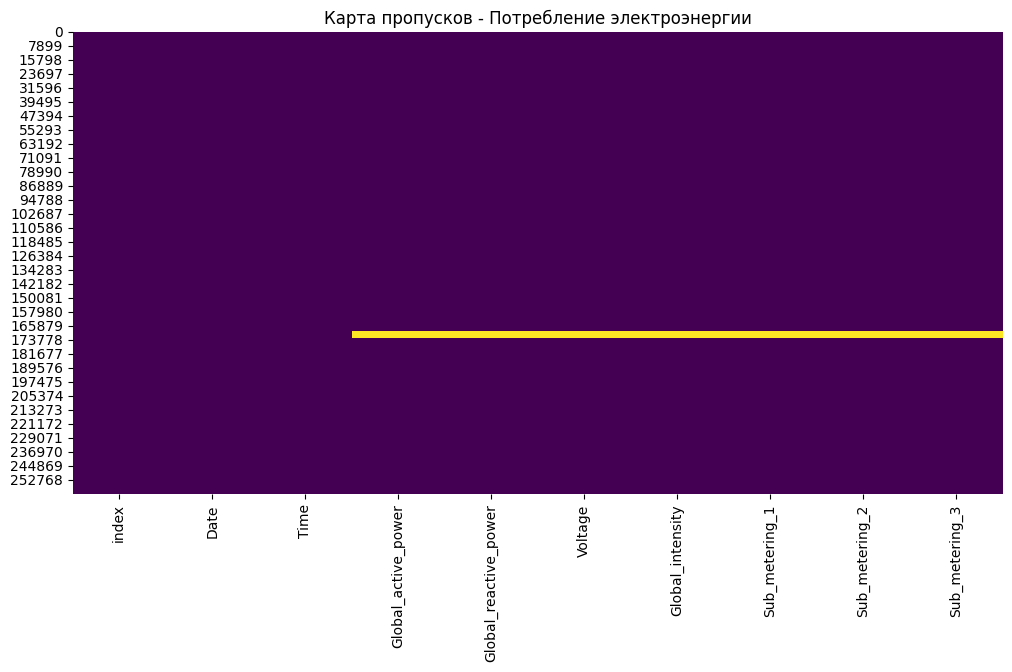

In [2]:
# Определяем все возможные значения пропусков
MISSING_VALUES = ['?', '', ' ', 'null', 'NULL', 'NaN', 'nan', 'None', 'N/A', 'n/a', '#N/A', '--', '-', '...', 'NA', 'na']

# Загрузка данных с обработкой пропусков и ПРАВИЛЬНЫМ форматом дат
df = pd.read_csv('df/isxod.csv', 
                 na_values=MISSING_VALUES,
                 low_memory=False,
                 dayfirst=True)  # Ключевое исправление! Указываем европейский формат

print(f"Размер данных: {df.shape}")
print(f"Первые 5 строк:")
print(f"{df.head()}\n")

# Анализ пропусков
def analyze_missing_data(dataframe, name):
    missing_total = dataframe.isnull().sum().sum()
    missing_percent = (missing_total / (dataframe.shape[0] * dataframe.shape[1])) * 100
    print(f"В наборе '{name}': {missing_total} пропусков ({missing_percent:.2f}%)")
    
    # Визуализация пропусков
    plt.figure(figsize=(12, 6))
    sns.heatmap(dataframe.isnull(), cbar=False, cmap='viridis')
    plt.title(f"Карта пропусков - {name}")
    plt.show()

analyze_missing_data(df, "Потребление электроэнергии")

#### Предобработка 

In [3]:
# Обработка пропусков 

# Проверяем пропуски до обработки
print(f"Пропуски до обработки: {df.isnull().sum().sum()}\n")

# Заполняем пропуски разными стратегиями для разных типов данных
for column in df.columns:
    if df[column].dtype in ['float64', 'int64']:
        # Для числовых - медианой (устойчива к выбросам)
        df[column] = df[column].fillna(df[column].median())
        print(f"Числовой столбец '{column}' заполнен медианой")

print(f"\nПропуски после обработки: {df.isnull().sum().sum()}")

Пропуски до обработки: 26397

Числовой столбец 'index' заполнен медианой
Числовой столбец 'Global_active_power' заполнен медианой
Числовой столбец 'Global_reactive_power' заполнен медианой
Числовой столбец 'Voltage' заполнен медианой
Числовой столбец 'Global_intensity' заполнен медианой
Числовой столбец 'Sub_metering_1' заполнен медианой
Числовой столбец 'Sub_metering_2' заполнен медианой
Числовой столбец 'Sub_metering_3' заполнен медианой

Пропуски после обработки: 0


В наборе 'Потребление электроэнергии': 0 пропусков (0.00%)


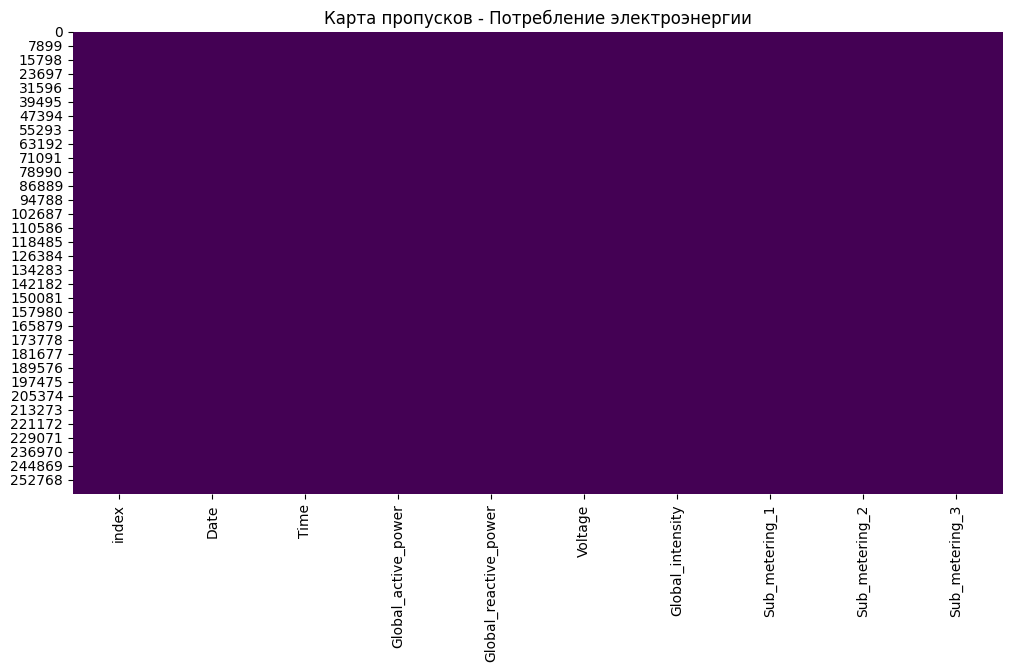

In [4]:
analyze_missing_data(df, "Потребление электроэнергии")

In [5]:
# Создаем datetime индекс С ПРАВИЛЬНЫМ ФОРМАТОМ
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)  # ДОБАВЛЕНО dayfirst=True
df = df.set_index('datetime')

# Удаляем исходные столбцы даты и времени
df = df.drop(['Date', 'Time'], axis=1)

# Удаляем столбец 'index' - теперь datetime индекс
df = df.drop('index', axis=1)

# Проверяем правильность распознавания дат ЧЕРЕЗ ИНДЕКС
print("ПРОВЕРКА ДАТ:")
print(f"Начало данных: {df.index.min()}")  # ИСПРАВЛЕНО: обращаемся к индексу
print(f"Конец данных: {df.index.max()}")    # ИСПРАВЛЕНО: обращаемся к индексу
print(f"Реальные месяцы в данных: {sorted(df.index.month.unique())}")  # ИСПРАВЛЕНО: через индекс

print("Временной индекс datetime создан")
print(f"Диапазон данных: от {df.index.min()} до {df.index.max()}")

ПРОВЕРКА ДАТ:
Начало данных: 2007-01-01 00:00:00
Конец данных: 2007-06-30 23:59:00
Реальные месяцы в данных: [1, 2, 3, 4, 5, 6]
Временной индекс datetime создан
Диапазон данных: от 2007-01-01 00:00:00 до 2007-06-30 23:59:00


In [6]:
# Создаем признаки времени (важно для сезонности)

df['hour'] = df.index.hour # (0-23)
# Пример: 
# 0 = полночь, 12 = полдень, 18 = 6 вечера
# Нужен чтобы модель понимала "ночные провалы" и "дневные пики"
# Зачем: Энергопотребление сильно зависит от времени суток


df['day_of_week'] = df.index.dayofweek # (0-6)
# 0 = понедельник, 1 = вторник, ..., 6 = воскресенье
# В данных: [0 3 6 1 4 2 5] - это просто порядок дней
# Зачем: Потребление в выходные отличается от рабочих дней


df['month'] = df.index.month # (1-12)
# 1 = январь, 12 = декабрь
# Зимой - отопление, летом - кондиционеры
# Зачем: Учесть сезонные изменения (отопление/кондиционирование)


df['is_weekend'] = (df.index.dayofweek >= 5).astype(int) # (0 или 1)
# 0 = рабочий день, 1 = суббота/воскресенье
# Упрощенная версия day_of_week
# Зачем: Быстро выделить выходные дни


print("Временные признаки созданы:")
print(f"Часы: {df['hour'].unique()}")
print(f"Дни недели: {df['day_of_week'].unique()}")
print(f"Месяцы: {sorted(df['month'].unique())}")

Временные признаки созданы:
Часы: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Дни недели: [0 1 2 3 4 5 6]
Месяцы: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6)]


In [7]:
df.sample(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,month,is_weekend
datetime,,,,,,,,,,,
2007-03-05 17:29:00,2.332,0.130,240.04,10.0,0.0,32.0,0.0,17,0,3,0
2007-03-26 11:26:00,1.604,0.108,238.44,6.8,0.0,0.0,17.0,11,0,3,0
2007-06-02 13:11:00,0.762,0.284,235.39,3.4,0.0,1.0,0.0,13,5,6,1
2007-06-11 15:43:00,0.274,0.240,243.61,1.4,0.0,1.0,0.0,15,0,6,0
2007-06-22 01:38:00,0.316,0.260,241.86,1.6,0.0,1.0,0.0,1,4,6,0


##### Описание столбцов датасета

| Столбец | Тип данных | Описание |
|---------|------------|-----------|
| **datetime** | DateTime | Временная метка (основной индекс) |
| **Global_active_power** | float64 | Общая активная мощность (кВт) - **целевая переменная** |
| **Global_reactive_power** | float64 | Общая реактивная мощность (кВт) |
| **Voltage** | float64 | Напряжение в сети (В) |
| **Global_intensity** | float64 | Общая сила тока (А) |
| **Sub_metering_1** | float64 | Потребление кухни (кВт) |
| **Sub_metering_2** | float64 | Потребление прачечной (кВт) |
| **Sub_metering_3** | float64 | Потребление систем отопления/охлаждения (кВт) |
| **hour** | int32 | Час дня (0-23) - **временной признак** |
| **day_of_week** | int32 | День недели (0=пн, 6=вс) - **временной признак** |
| **month** | int32 | Месяц года (1-12) - **временной признак** |
| **is_weekend** | int32 | Признак выходного дня (0=рабочий, 1=выходной) - **временной признак** |

##### Ключевые особенности:
- 🎯 **Global_active_power** - основная целевая переменная для прогнозирования
- ⏰ Временные признаки созданы для анализа сезонности
- 📊 Данные собраны с минутным интервалом
- 🏠 Sub_metering показывают потребление по зонам дома
- ⚡ Энергетические параметры взаимосвязаны (мощность, напряжение, ток)

In [8]:
# Сохраняем обработанные данные
df.to_csv('df/obr.csv')
print("Обработанные данные сохранены в 'df/obr.csv'")

# Также сохраним sample для проверки
sample_df = df.sample(300)  # 300 случайных строк
sample_df.to_csv('df/obr_sample.csv')
print("Sample данных сохранен в 'df/obr_sample.csv'")

# Проверим размер сохраненных данных
print(f"\nРазмер полного датасета: {df.shape}")
print(f"Размер sample: {sample_df.shape}")

Обработанные данные сохранены в 'df/obr.csv'
Sample данных сохранен в 'df/obr_sample.csv'

Размер полного датасета: (260640, 11)
Размер sample: (300, 11)


#### Анализ

Визуализируем распределение:


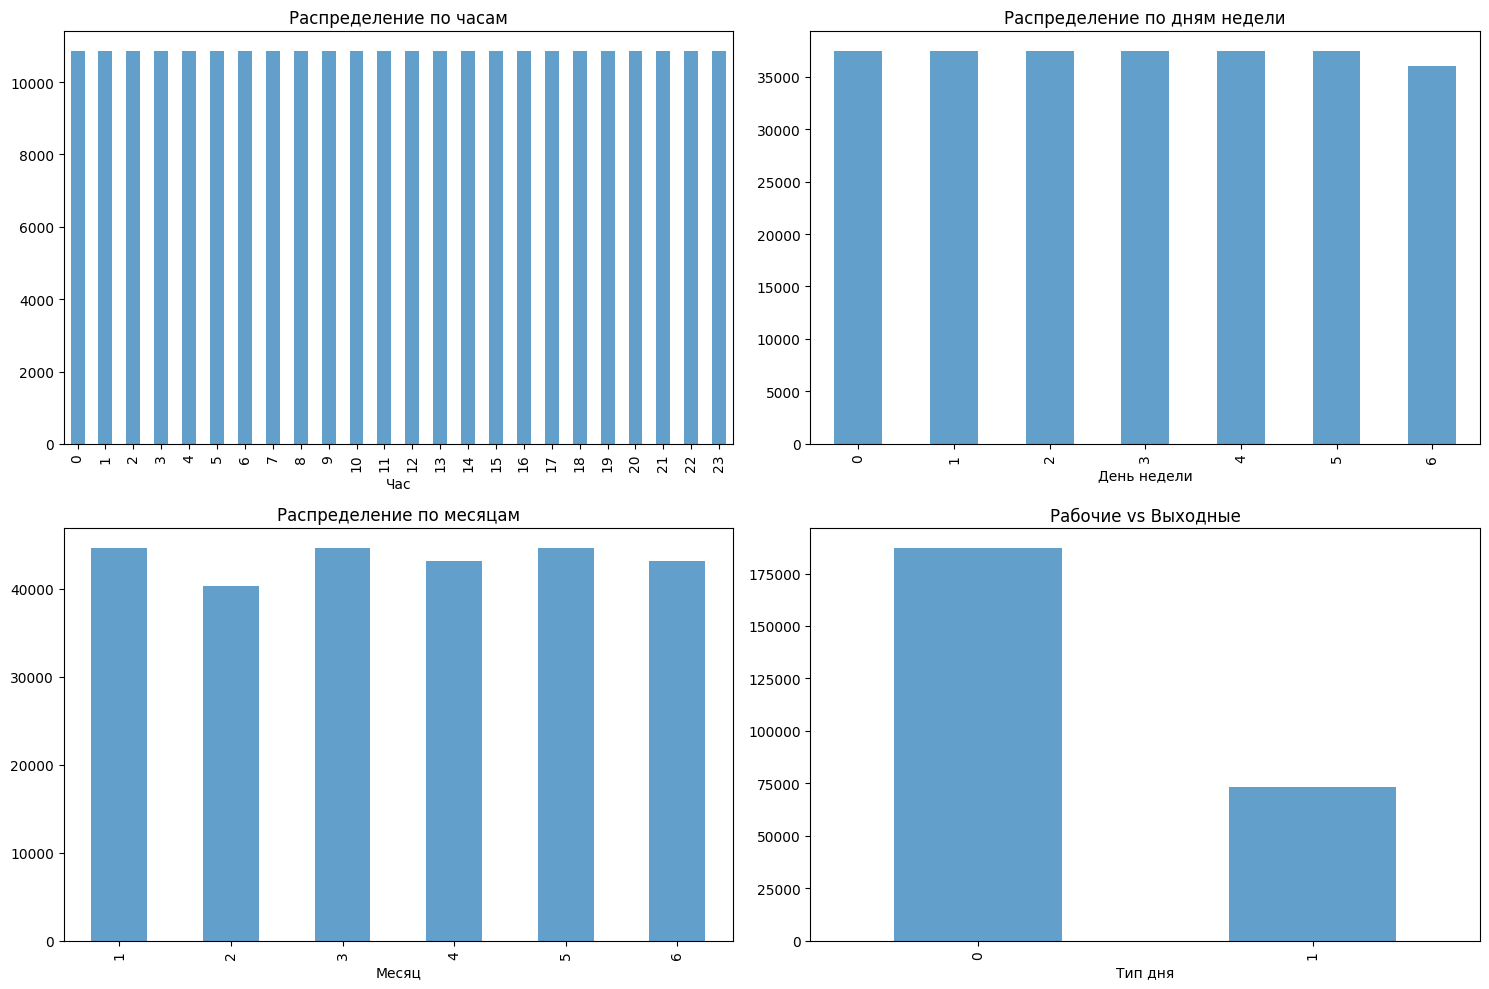

In [9]:
print("Визуализируем распределение:")

# Визуализируем распределение
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
df['hour'].value_counts().sort_index().plot(kind='bar', alpha=0.7)
plt.title('Распределение по часам')
plt.xlabel('Час')

plt.subplot(2, 2, 2)
df['day_of_week'].value_counts().sort_index().plot(kind='bar', alpha=0.7)
plt.title('Распределение по дням недели')
plt.xlabel('День недели')

plt.subplot(2, 2, 3)
df['month'].value_counts().sort_index().plot(kind='bar', alpha=0.7)
plt.title('Распределение по месяцам')
plt.xlabel('Месяц')

plt.subplot(2, 2, 4)
df['is_weekend'].value_counts().plot(kind='bar', alpha=0.7)
plt.title('Рабочие vs Выходные')
plt.xlabel('Тип дня')

plt.tight_layout()
plt.show()

Анализ целевой переменной (Global_active_power):
Среднее потребление: 1.16 кВт
Максимальное потребление: 10.67 кВт
Минимальное потребление: 0.08 кВт
Количество записей: 260640


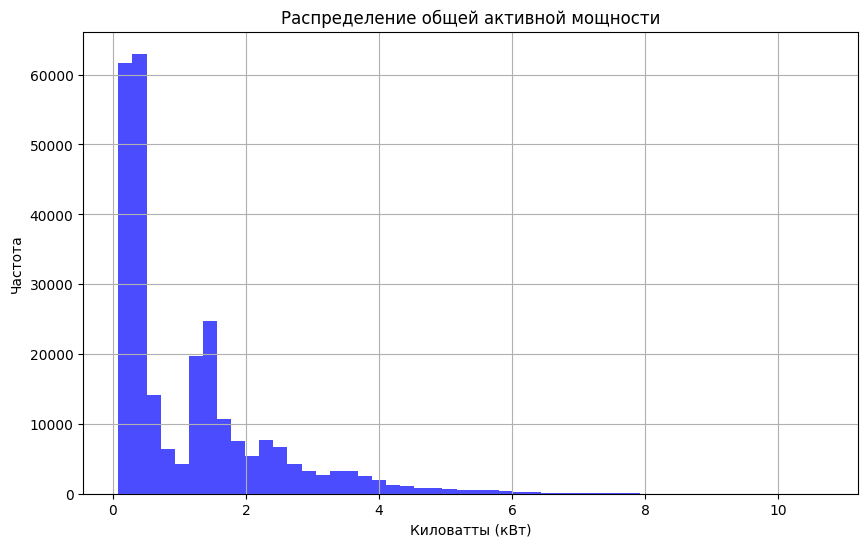

In [10]:
# Анализируем целевую переменную
print(f"Анализ целевой переменной (Global_active_power):")
print(f"Среднее потребление: {df['Global_active_power'].mean():.2f} кВт")
print(f"Максимальное потребление: {df['Global_active_power'].max():.2f} кВт") 
print(f"Минимальное потребление: {df['Global_active_power'].min():.2f} кВт")
print(f"Количество записей: {len(df)}")

# Визуализируем распределение
plt.figure(figsize=(10, 6))
plt.hist(df['Global_active_power'].dropna(), bins=50, alpha=0.7, color='blue')
plt.title('Распределение общей активной мощности')
plt.xlabel('Киловатты (кВт)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Анализ суточной сезонности:
Наблюдения по суточной сезонности:
Минимальное потребление: 0.49 кВт в 4:00
Максимальное потребление: 2.18 кВт в 21:00


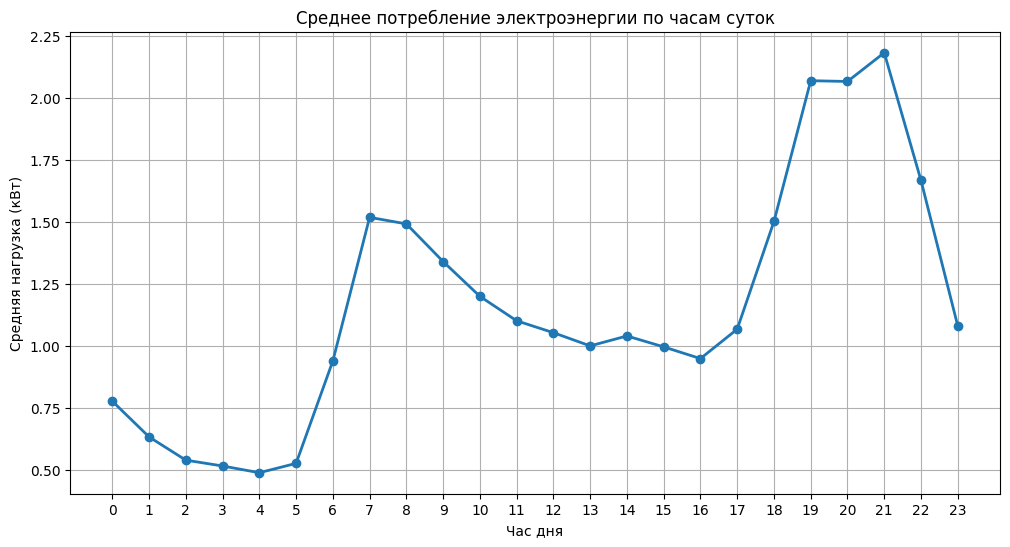

In [11]:
# Анализ суточной сезонности
print("Анализ суточной сезонности:")

# Группируем по часам и считаем среднюю нагрузку
hourly_pattern = df.groupby('hour')['Global_active_power'].mean()

print("Наблюдения по суточной сезонности:")
print(f"Минимальное потребление: {hourly_pattern.min():.2f} кВт в {hourly_pattern.idxmin()}:00")
print(f"Максимальное потребление: {hourly_pattern.max():.2f} кВт в {hourly_pattern.idxmax()}:00")

plt.figure(figsize=(12, 6))
plt.plot(hourly_pattern.index, hourly_pattern.values, marker='o', linewidth=2)
plt.title('Среднее потребление электроэнергии по часам суток')
plt.xlabel('Час дня')
plt.ylabel('Средняя нагрузка (кВт)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

Анализ недельной сезонности:
Статистика потребления по дням недели:
Понедельник: 1.09 ± 1.06 кВт (мин: 0.08, макс: 9.49)
Вторник: 0.96 ± 1.02 кВт (мин: 0.08, макс: 8.67)
Среда: 1.21 ± 1.15 кВт (мин: 0.08, макс: 8.97)
Четверг: 1.04 ± 1.11 кВт (мин: 0.10, макс: 9.41)
Пятница: 0.94 ± 0.98 кВт (мин: 0.08, макс: 7.61)
Суббота: 1.29 ± 1.29 кВт (мин: 0.10, макс: 9.27)
Воскресенье: 1.58 ± 1.42 кВт (мин: 0.10, макс: 10.67)


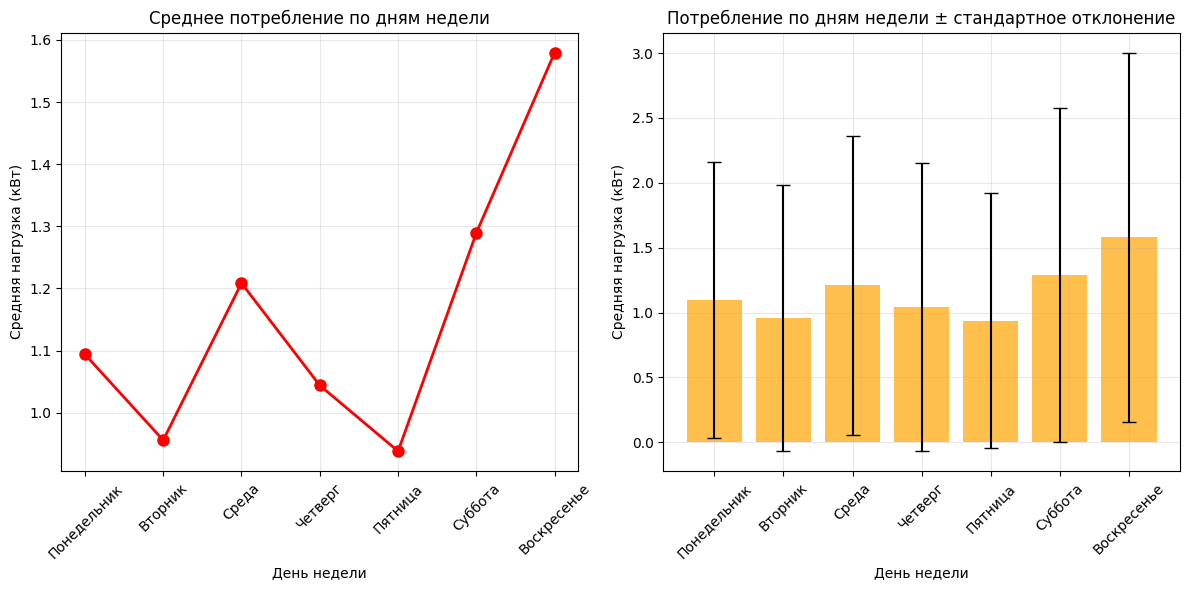

СРАВНЕНИЕ РАБОЧИХ И ВЫХОДНЫХ:
Среднее потребление в рабочие дни: 1.05 кВт
Среднее потребление в выходные: 1.43 кВт
Разница: +36.6%


In [12]:
# НЕДЕЛЬНАЯ СЕЗОННОСТЬ - среднее потребление по дням недели
print("Анализ недельной сезонности:")

# Создаем словарь для правильных названий дней недели
days_map = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 
            4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}

# Группируем по дням недели и считаем статистику
weekly_pattern = df.groupby('day_of_week')['Global_active_power'].agg(['mean', 'std', 'min', 'max'])

print("Статистика потребления по дням недели:")
for day in weekly_pattern.index:
    day_name = days_map[day]
    stats = weekly_pattern.loc[day]
    print(f"{day_name}: {stats['mean']:.2f} ± {stats['std']:.2f} кВт (мин: {stats['min']:.2f}, макс: {stats['max']:.2f})")

# Визуализация
plt.figure(figsize=(12, 6))

# Линейный график
plt.subplot(1, 2, 1)
plt.plot([days_map[i] for i in weekly_pattern.index], weekly_pattern['mean'], 
         marker='o', linewidth=2, markersize=8, color='red')
plt.title('Среднее потребление по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средняя нагрузка (кВт)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Столбчатая диаграмма с ошибками
plt.subplot(1, 2, 2)
plt.bar([days_map[i] for i in weekly_pattern.index], weekly_pattern['mean'], 
        yerr=weekly_pattern['std'], capsize=5, alpha=0.7, color='orange')
plt.title('Потребление по дням недели ± стандартное отклонение')
plt.xlabel('День недели')
plt.ylabel('Средняя нагрузка (кВт)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ разницы рабочих/выходных
workdays = df[df['is_weekend'] == 0]['Global_active_power'].mean()
weekends = df[df['is_weekend'] == 1]['Global_active_power'].mean()
difference = ((weekends - workdays) / workdays) * 100

print(f"СРАВНЕНИЕ РАБОЧИХ И ВЫХОДНЫХ:")
print(f"Среднее потребление в рабочие дни: {workdays:.2f} кВт")
print(f"Среднее потребление в выходные: {weekends:.2f} кВт")
print(f"Разница: {difference:+.1f}%")

Анализ месячной сезонности:
Статистика потребления по месяцам:
Январь: 1.55 ± 1.29 кВт (записей: 44640.0)
Февраль: 1.40 ± 1.31 кВт (записей: 40320.0)
Март: 1.32 ± 1.28 кВт (записей: 44640.0)
Апрель: 0.86 ± 0.95 кВт (записей: 43200.0)
Май: 0.99 ± 1.01 кВт (записей: 44640.0)
Июнь: 0.83 ± 0.95 кВт (записей: 43200.0)


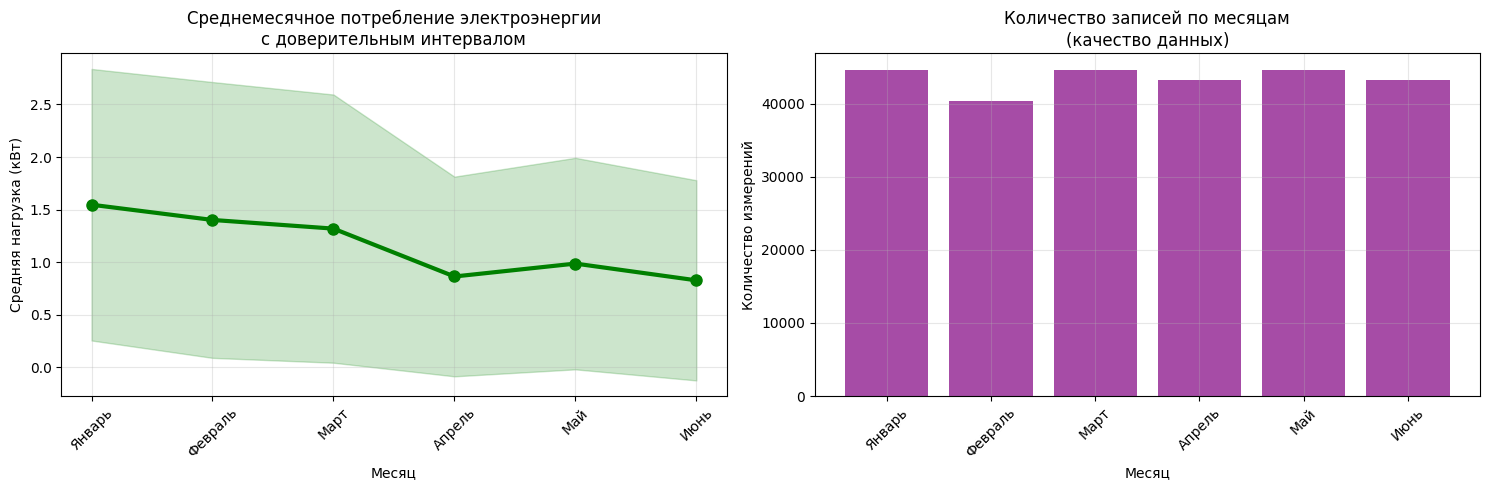

🌡️ СЕЗОННЫЕ КОЛЕБАНИЯ:
Среднее потребление зимой: 1.47 кВт
Среднее потребление летом: 0.83 кВт
Разница: -43.9%

📈 Экстремумы:
Максимальное потребление: Январь (1.55 кВт)
Минимальное потребление: Июнь (0.83 кВт)


In [13]:
# МЕСЯЧНАЯ СЕЗОННОСТЬ - как потребление меняется по месяцам
print("Анализ месячной сезонности:")

# Создаем словарь для названий месяцев
months_map = {1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 
              5: 'Май', 6: 'Июнь', 7: 'Июль', 8: 'Август',
              9: 'Сентябрь', 10: 'Октябрь', 11: 'Ноябрь', 12: 'Декабрь'}

# Группируем по месяцам и считаем статистику
monthly_pattern = df.groupby('month')['Global_active_power'].agg(['mean', 'std', 'min', 'max', 'count'])

print("Статистика потребления по месяцам:")
for month in monthly_pattern.index:
    month_name = months_map[month]
    stats = monthly_pattern.loc[month]
    print(f"{month_name}: {stats['mean']:.2f} ± {stats['std']:.2f} кВт (записей: {stats['count']})")

# Визуализация
plt.figure(figsize=(15, 5))

# Основной график потребления по месяцам
plt.subplot(1, 2, 1)
months_list = [months_map[i] for i in monthly_pattern.index]
plt.plot(months_list, monthly_pattern['mean'], marker='o', linewidth=3, markersize=8, color='green')
plt.fill_between(months_list, 
                 monthly_pattern['mean'] - monthly_pattern['std'],
                 monthly_pattern['mean'] + monthly_pattern['std'],
                 alpha=0.2, color='green')
plt.title('Среднемесячное потребление электроэнергии\nс доверительным интервалом')
plt.xlabel('Месяц')
plt.ylabel('Средняя нагрузка (кВт)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Количество записей по месяцам (качество данных)
plt.subplot(1, 2, 2)
plt.bar(months_list, monthly_pattern['count'], alpha=0.7, color='purple')
plt.title('Количество записей по месяцам\n(качество данных)')
plt.xlabel('Месяц')
plt.ylabel('Количество измерений')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ сезонных паттернов
winter_months = [1, 2 ]  # Январь, Февраль
summer_months = [6]   # Июнь

winter_consumption = monthly_pattern.loc[winter_months, 'mean'].mean()
summer_consumption = monthly_pattern.loc[summer_months, 'mean'].mean()
seasonal_difference = ((summer_consumption - winter_consumption) / winter_consumption) * 100

print(f"🌡️ СЕЗОННЫЕ КОЛЕБАНИЯ:")
print(f"Среднее потребление зимой: {winter_consumption:.2f} кВт")
print(f"Среднее потребление летом: {summer_consumption:.2f} кВт")
print(f"Разница: {seasonal_difference:+.1f}%")

# Находим месяц с максимальным и минимальным потреблением
max_month_idx = monthly_pattern['mean'].idxmax()
min_month_idx = monthly_pattern['mean'].idxmin()
print(f"\n📈 Экстремумы:")
print(f"Максимальное потребление: {months_map[max_month_idx]} ({monthly_pattern.loc[max_month_idx, 'mean']:.2f} кВт)")
print(f"Минимальное потребление: {months_map[min_month_idx]} ({monthly_pattern.loc[min_month_idx, 'mean']:.2f} кВт)")

Визуализация временного ряда:


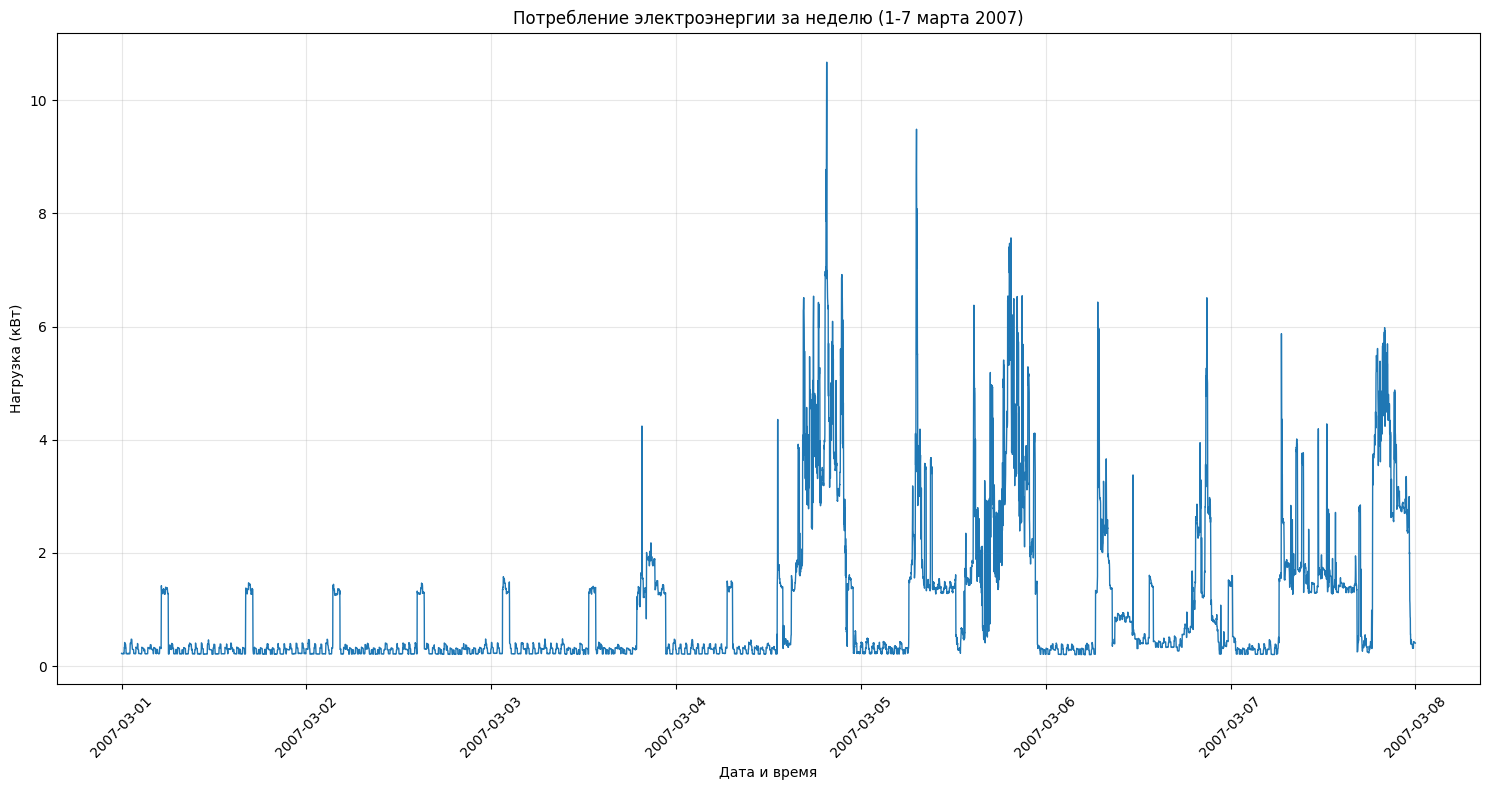

In [14]:
# Визуализация временного ряда за несколько дней
print("Визуализация временного ряда:")

# Выбираем случайную неделю для демонстрации
sample_week = df['2007-03-01':'2007-03-07']  # Любая неделя из данных

plt.figure(figsize=(15, 8))
plt.plot(sample_week.index, sample_week['Global_active_power'], linewidth=1)
plt.title('Потребление электроэнергии за неделю (1-7 марта 2007)')
plt.xlabel('Дата и время')
plt.ylabel('Нагрузка (кВт)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Анализ автокорреляции:


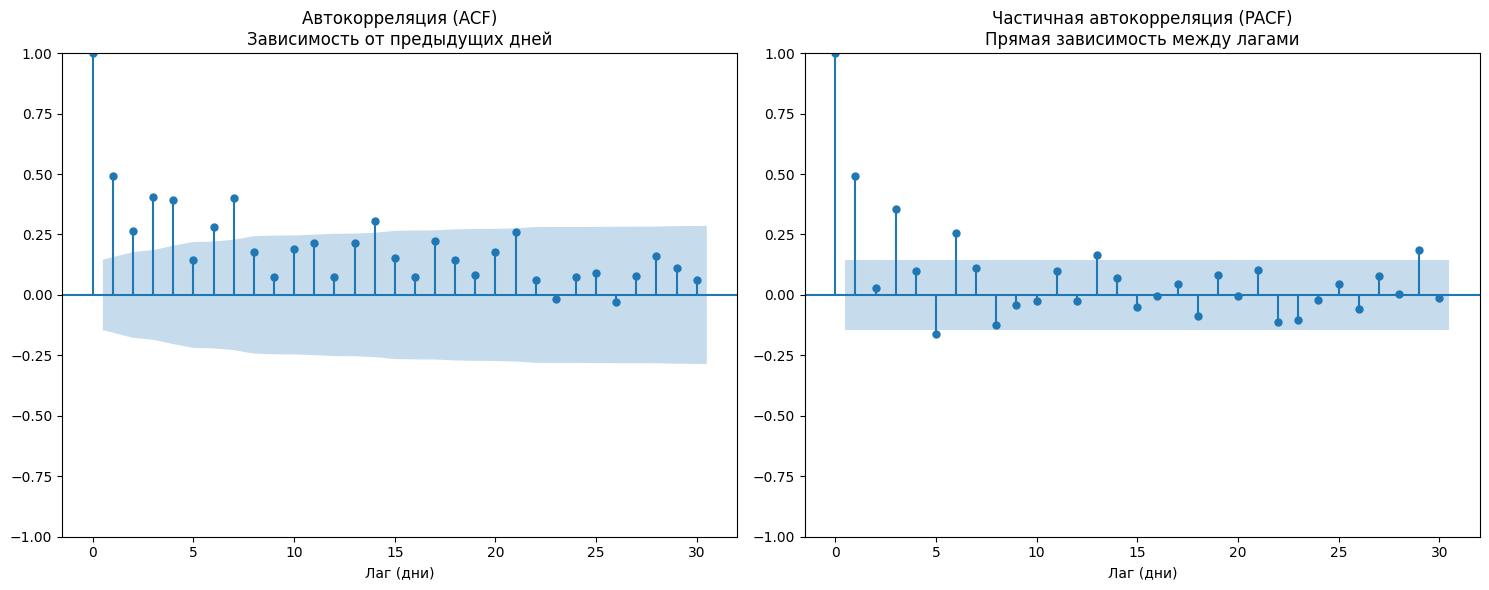

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print("Анализ автокорреляции:")

# Берем дневные средние для лучшей визуализации
daily_data = df['Global_active_power'].resample('D').mean()

plt.figure(figsize=(15, 6))

# Автокорреляционная функция (ACF)
plt.subplot(1, 2, 1)
plot_acf(daily_data, lags=30, ax=plt.gca(), alpha=0.05)
plt.title('Автокорреляция (ACF)\nЗависимость от предыдущих дней')
plt.xlabel('Лаг (дни)')

# Частичная автокорреляционная функция (PACF)  
plt.subplot(1, 2, 2)
plot_pacf(daily_data, lags=30, ax=plt.gca(), alpha=0.05)
plt.title('Частичная автокорреляция (PACF)\nПрямая зависимость между лагами')
plt.xlabel('Лаг (дни)')

plt.tight_layout()
plt.show()

Тепловая карта сезонности:


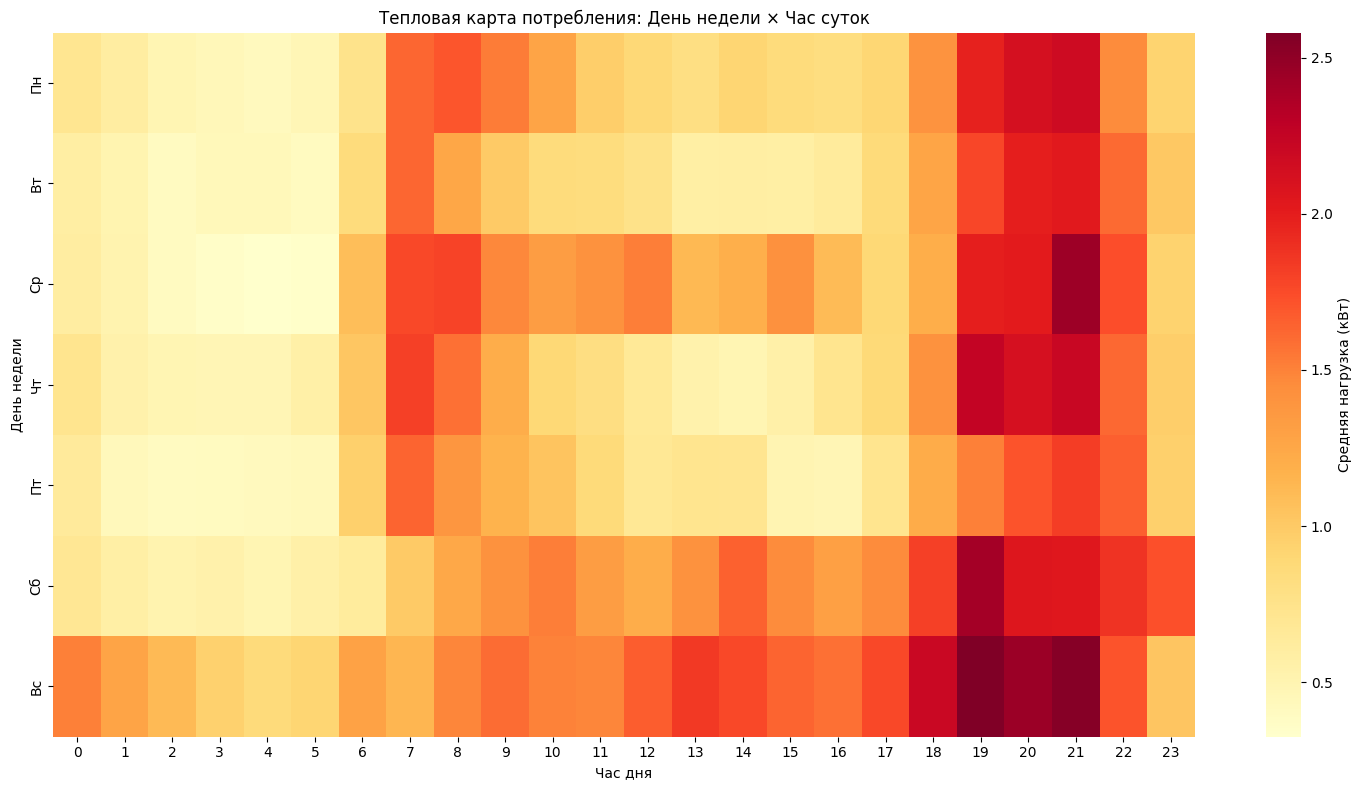

In [16]:
# Создаем тепловую карту "час дня × день недели"
print("Тепловая карта сезонности:")

# Группируем по часу и дню недели
heatmap_data = df.groupby(['day_of_week', 'hour'])['Global_active_power'].mean().unstack()

plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_data, 
            cmap='YlOrRd', 
            annot=False,  # Можно поставить True если хотите числа
            cbar_kws={'label': 'Средняя нагрузка (кВт)'})
plt.title('Тепловая карта потребления: День недели × Час суток')
plt.xlabel('Час дня')
plt.ylabel('День недели')
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], 
           labels=['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.tight_layout()
plt.show()